# Derived from Geron 11_deep_learning.ipynb

We will provide a quick introduction into programming with TensorFlow.

We revist our old friend, MNIST digit classification and provide a solution using the high-level Keras API

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

In [2]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.4.1
Version 2, minor 4


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


2024-03-29 11:15:16.549885: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [4]:
import tensorflow as tf

import numpy as np
import os

import pdb

from pprint import pprint

# Get the MNIST dataset
- data pre-split into training and test sets
  - flatten the images from 2 dimensional to 1 dimensional (makes it easier to feed into first layer)
  - create validation set from part of training
- "normalize" the inputs: change pixel range from [0,255] to [0,1]

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Determine
# - the dimensions of the input by examining the first training example
# - the dimensions of the output (number of classes) by examinimg the targets
input_size = np.prod(X_train[0].shape)
output_size = np.unique(y_train).shape[0]

# input image dimensions
img_rows, img_cols = X_train[0].shape[0:2]

valid_size = X_train.shape[0] // 10

# Flatten the data to one dimension and normalize to range [0,1]
X_train = X_train.astype(np.float32).reshape(-1, input_size) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, input_size) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:valid_size], X_train[valid_size:]
y_valid, y_train = y_train[:valid_size], y_train[valid_size:]

In [6]:
X_train.shape

(54000, 784)

In [7]:
n_epochs = 20
batch_size = 50

(n_hidden_1, n_hidden_2) = (100, 30)
modelName = "mnist_first"


# Keras version

That was very instructive (hopefully) but also a lot of detailed work.

It's worthwhile studying the TensorFlow.layers to get a deeper understanding of
- computation graph
  -definition
  - initialization
  - evaluation
- loss functions:
  - computed per example and summed
- the training loop

Over the years, many people have created higher level abstractions (e.g., `tf.layers.dense` is an abstraction that saves you the trouble of multiplying inputs by weights, adding a bias, and applying an activation) to both simplify and reduce repeated code patterns.

The Keras API is a very high level abstraction (that looks similar to `sklearn` in some regards) that simplifies things a great deal, and will be tightly integrated into TensorFlow 2.0

Let's re-implement this classification problem in Keras

## Boiler plate

Here are some of our standard imports.

Note that - `keras` and - `tensorflow.keras` are two very similar but **distinct** modules !  
- `keras` is a  [project](https://keras.io/) that is separate and distinct from TensorFlow
  - It is an API for Neural Network programming, not a library
  - The API can be implemented for many different compute engines.  TensorFlow is just one engine
  - The Keras project supplies a TensorFlow engine which is **not identical** to Google's tTensorFlow implementation
  
- `tensorflow.keras` is Google's implementation (and extension) of the Keras API

For the most part they are similar, but you can create difficulty if you mix and match.
We will deal exclusively with `tensorflow.keras`, as will be reflected in our import statements.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

from tensorflow.keras.utils import plot_model
import IPython


## Build the compuation graph in Keras

In [9]:
mnist_model = Sequential([ layers.Dense(n_hidden_1, activation=tf.nn.relu,    name="hidden1", input_shape=(input_size,)),
                           layers.Dense(n_hidden_2, activation=tf.nn.relu,    name="hidden2"),
                           layers.Dense(output_size,activation=tf.nn.softmax, name="outputs")
                         ]
                        )



2024-03-29 11:15:17.235994: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 11:15:17.237332: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


That was easy !

We used the same conceptual layers as in the TensorFlow.layers implementation and passed them as a list to the `Sequential` model.
Note, however, that the "layers" now come from tf.keras rather than TensorFlow tf.

The `Sequential` model will take the input, feed it to the first layer, and pass the output of layer $i$ to the input of layer $i+1$.

Some things to point out
- when you use the `Sequential` model, you don't supply an explicit `Input` layer (placeholders in TensorFlow.layers)
  - instead: the first (and only the first) layer requires the `input_shape` argument to describe the shape of the input
- Unlike in the TensorFlow.layers code, the  final layer (`outputs`) has an `softmax` activation
  - In TensorFlow.layers, the loss function (`sparse_softmax_cross_entropy_with_logits`) performs its own `softmax`
    - we couldn't find a similar loss function in Keras, so we perform the `softmax` ourself.

### Creating a loss node  and training operation in Keras

The `mnist_model` specifies the layers of the model, but doesn't actually build the computation graphs.
For that, we need to "compile" the model.

The compile step is also where we specify
- the loss function
- the optimizer step
- other "metrics" (values to measure) to compute in the training loop

Below
- we will use `sparse_categorical_crossentropy` as the loss (`sparse` because our labels are not one-hot encoded).
- `adam` as our optimizer (could have easily chosen `sgd`in order to be more similar to the TensorFlow.layers code)
- measure training accuracy (`acc`)

In [10]:
metrics = [ "accuracy" ]
mnist_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=metrics)


## History and callbacks

Strictly speaking, the next few cells are not absolutely necessary: they go far beyond what our TensorFlow.layers program accomplishes
- call backs
  - these are functions that are called automatically in the training loop
    - `EarlyStopping`is a call back that will terminate the training loop when it is no longer productive to continue (e.g., when validation loss levels off)
    - `ModelCheckpoint` is a call back that will create intermediate snapshots of our model (including the parameters/weights it has learned)
      - We will create a checkpoint whenever accuracy improves.  So if further training reduces accuracy, we can restore back to the "best" parameter values.
      - This means we can re-start the model and continue to train without losing the "best" values.
      - In the TensorFlow.layers code, we only created a single checkpoint at the end of training
  

In [11]:
import matplotlib.pyplot as plt

def plot_training(history):
    """
    Plot training and validation statistics
    - accuracy vs epoch number
    - loss     vs epoch number

    From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
    """

    metrics = list( history.history.keys() )

    # Loss
    loss = history.history['loss']

    epochs = range(len(loss))

    fig, axs = plt.subplots( len(metrics)// 2, 2, figsize=(9,6))
    axs = axs.flatten()

    for i, metric in enumerate(metrics):
      ax = axs[i]
      metric_value = history.history[metric]
      ax.plot(epochs, metric_value, 'b', label=metric)
      ax.set_title(metric)
      ax.legend()

    plt.show()

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

import os

logs_dir="logs/fit/"
os.makedirs( ".", exist_ok=True)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
log_dir= os.path.join(logs_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


2024-03-29 11:15:17.854052: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-03-29 11:15:17.854071: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-03-29 11:15:17.854103: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


### Create call backs
- Early Stopping
- Model Checkpoint

In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

callbacks = [ es_callback,
              ModelCheckpoint(filepath=modelName + "_ckpt" + ".keras", monitor='val_accuracy', mode='max', save_best_only=True)
          ]


## Run the training loop in Keras

Now that the model is compiled, we can run `fit` on our training (and validation) data sets/

This is very much  like `sklearn`.

Note
- We don't have to construct our own training loop
- We don't have to create code to deliver mini-batches
- We don't have to insert code to display metrics (like accuracy)
- We don't have to run for the full set of epochs, because of Early Stopping

See how much simpler this step is compared to TensorFlow.layers.

In [14]:
history = mnist_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), shuffle=True, callbacks=callbacks)



2024-03-29 11:15:18.122798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-29 11:15:18.141025: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/20
1080/1080 [==============================] - 3s 3ms/step - loss: 0.5426 - accuracy: 0.8479 - val_loss: 0.1645 - val_accuracy: 0.9537
Epoch 2/20
1080/1080 [==============================] - 4s 3ms/step - loss: 0.1440 - accuracy: 0.9567 - val_loss: 0.1238 - val_accuracy: 0.9630
Epoch 3/20
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0963 - accuracy: 0.9710 - val_loss: 0.1005 - val_accuracy: 0.9703
Epoch 4/20
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0705 - accuracy: 0.9786 - val_loss: 0.0877 - val_accuracy: 0.9757
Epoch 5/20
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0572 - accuracy: 0.9830 - val_loss: 0.0829 - val_accuracy: 0.9743
Epoch 6/20
1080/1080 [==============================] - 2s 2ms/step - loss: 0.0449 - accuracy: 0.9860 - val_loss: 0.0756 - val_accuracy: 0.9752
Epoch 7/20
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0347 - accuracy: 0.9892 - val_loss: 0.1018 - val_accuracy:

### Compute the accuracy on the test set

In [15]:
test_loss, test_accuracy = mnist_model.evaluate(X_test, y_test)
print("Test dataset: loss={tl:5.4f}, accuracy={ta:5.4f}".format(tl=test_loss, ta=test_accuracy))

313/313 [==============================] - 1s 1ms/step - loss: 0.0811 - accuracy: 0.9744
Test dataset: loss=0.0811, accuracy=0.9744


## See the training history

The `fit` method returns a `history` object, which contains a time-series (across the epochs) of each metric.

You automatically get a `loss` metric so you can see how quickly your training loss decreases.

In the compile step, you can add other metric (like accuracy, both for training and validation).

Because these metrics are time series, we can visualize them.

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

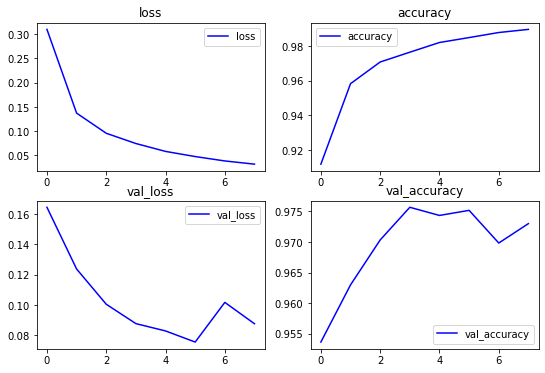

In [17]:
plot_training(history)

## Use the model for prediction

Just as with `sklearn`, once we have fit the model, we can use the `predict` method to map inputs to predictions.
- Remember: the `outputs` layer has 10 elements, one per output class (so it is one-hot encoded)

In [18]:
predictions = mnist_model.predict(X_test)
predictions.shape

(10000, 10)

## Examine the model

Observe the number of parameters (weights) that the model requires.  Is it larger than you thought ?

In [19]:
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 30)                3030      
_________________________________________________________________
outputs (Dense)              (None, 10)                310       
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


## Bonus: Visualize the model's layers !


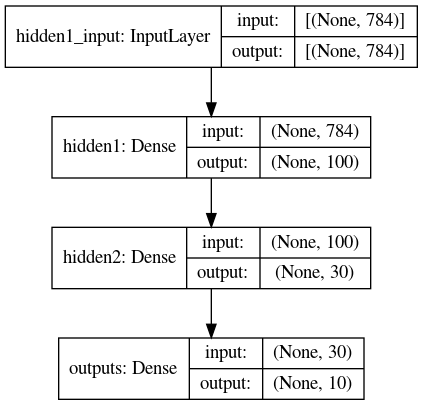

In [20]:
plot_model(mnist_model, "mnist_model.png", show_shapes=True)
IPython.display.Image(  "mnist_model.png")

## Save the model (architecture + weights + optimizer state))

In [21]:
from tensorflow.keras.models import load_model

modelName = "mnist_first"

model_path = os.path.join(".", modelName + ".keras")
mnist_model.save(model_path)  


## Load a saved model

In [22]:
# returns a compiled model
# identical to the previous one
mnist_model_1 = load_model(model_path)

### Show that the restored model works

In [23]:
mnist_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 30)                3030      
_________________________________________________________________
outputs (Dense)              (None, 10)                310       
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


In [24]:
predictions_1 = mnist_model_1.predict(X_test)
predictions_1.shape

all_match = np.all(predictions == predictions_1)
if all_match:
  answer = "YES"
else:
  answer = "NO"

print("Live model and restore model results match ?", answer)

Live model and restore model results match ? YES


# Hyper-parameter search: Keras tuner

How many units should be in my non-head `Dense` layers ?
- You can experiment by hand
- You can make the number of units a *hyper-paramter* and have Keras search for the best value

**The Tuner is VERY SLOW without a GPU**
- I highly recommend using a GPU on this section

In [25]:
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/NYU/demo"

  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
else:
    raise RuntimeError("This notebook should be run from Colab, not on the local machine")

RuntimeError: This notebook should be run from Colab, not on the local machine

In [ ]:
# Change to demo directory so tuner-related output files are saved in common place
if IN_COLAB:
  import os
  kt_demo_dir = os.path.join(drive_root, "Keras_tuner")
  %cd $kt_demo_dir

In [ ]:
# Make sure necessary packages are present

import pkg_resources
import sys
import subprocess

required = {'keras_tuner'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    rc = subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

    if rc == 0:
      print("Installed: ", ", ".join( list(missing) ) )

## Here is the tuning code

In [ ]:
# You may need to `pip install keras-tuner` before running the import

import keras_tuner as kt

In [ ]:
def build_model(hp):

    ## Tunable hyperparameters
    hp_dropout1_units = hp.Float("dropout_1", min_value=0., max_value=0.9, step=0.3)
    hp_dropout2_units = hp.Float("dropout_2", min_value=0., max_value=0.9, step=0.3)

    hp_dense1_units = hp.Int("dense_1", min_value=8, max_value=24, step=8)
    hp_dense2_units = hp.Int("dense_2", min_value=8, max_value=24, step=8)

    ## Tune the learning rate for the optimizer
    ## Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    optimizer= tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    # The model
    model = tf.keras.Sequential()

    # Block 1: Dropout + Dense
    model.add(tf.keras.layers.Dense( hp_dense1_units, activation="relu", input_shape=(input_size,) ) )
    model.add(tf.keras.layers.Dropout( hp_dropout1_units ) )

    # Block 2: Dropout + Dense
    model.add(tf.keras.layers.Dense( hp_dense2_units, activation="relu" ) )
    model.add(tf.keras.layers.Dropout( hp_dropout2_units ) )

    # Head layer
    model.add(tf.keras.layers.Dense(output_size,activation=tf.nn.softmax) )

    model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)

    return model

In [ ]:
## HyperBand algorithm from keras tuner
overwrite_results=True # Set to False if you want to RE-USE results of previously run search

tuner = kt.Hyperband(build_model, objective='val_accuracy',
    max_epochs=10,
    directory='keras_tuner_dir', project_name='dnn_keras_tuner_demo',
    overwrite=overwrite_results)

# tuner.search(X_train, y_train, epochs=50, validation_split=0.1)
tuner.search(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), shuffle=True, callbacks=callbacks)


In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
best_model.summary()


In [ ]:
plot_model(best_model, show_shapes=True)

## Find the values of the hyperparameters for the top trials

In [ ]:
best_hps = tuner.get_best_hyperparameters(2)

In [ ]:
print("Best hyper parameter values:")
pprint( best_hps[0].values )



In [ ]:
print("Second Best hyper parameter values:")
pprint( best_hps[1].values )


In [ ]:
print("Best hyper parameter values:")
best_hps[0].values



In [ ]:
print("Second Best hyper parameter values:")
best_hps[1].values


In [ ]:
tuner.results_summary(num_trials=2)

In [ ]:
historyX = best_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), shuffle=True, callbacks=callbacks)

In [ ]:
_= plot_training( historyX )

In [ ]:
print("Done")